In [1]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler



!pip -qq install skorch xgboost

In [2]:
def plot_prediction_vs_truth(y_test, y_pred, tolerance=0.2, model="", title="Prediction vs Truth"):    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label="Predictions")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit")

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)*(1-tolerance)], linestyle = 'dotted', label=f"Deviation of {tolerance*100}%", color="orange")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)*(1+tolerance)], linestyle = 'dotted', label=f"Deviation of {-tolerance*100}%", color="black")

    plt.title(f"{model} {title}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")


def plot_residuals(y_test, y_pred, tolerance=0.2, model="", title="Residual Plot"):
    residuals = y_test - y_pred
    upper_tol = np.array([
        tolerance*y for y in y_test.sort_values()
    ])
    lower_tol = -1* upper_tol

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
    plt.axhline(0, color='red', linestyle='--', label="Zero Error")
    plt.plot(y_test.sort_values(), upper_tol, linestyle = '--', label=f"Deviation of {tolerance*100}%", color="orange")
    plt.plot(y_test.sort_values(), lower_tol, linestyle = '--', label=f"Deviation of {-tolerance*100}%", color="orange")
    plt.title(f"{model}: {title}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Truth - Prediction)")
    plt.legend()
    plt.grid()
    plt.show()


def plot_predictions_and_truth(y_test, y_pred, x_values=None, model="", title="Prediction vs Truth"):
    plt.figure(figsize=(10, 6))

    if x_values is None:
        x_values = range(len(y_test))

    plt.plot(x_values, y_test, label="True Values", color='blue', marker='o', linestyle='-', alpha=0.7)
    plt.plot(x_values, y_pred, label="Predicted Values", color='orange', marker='x', linestyle='--', alpha=0.7)

    plt.title(f"{model} {title}")
    plt.xlabel("Index or Feature")
    plt.ylabel("Values")
    plt.legend()
    plt.grid()
    plt.show()



# Loading data

In [3]:
df = pd.read_csv("sbern_2_clean_data_PCA.csv")
df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC176,PC177,PC178,PC179,PC180,PC181,PC182,PC183,max_salary,min_salary
0,0.267880,-0.226714,-0.015144,0.207767,-0.135909,0.034867,0.135928,-0.071531,-0.182865,-0.068760,...,-0.003003,-0.003571,0.011629,-0.000715,0.035844,-0.000837,0.020913,-0.024112,140000.0,120000.0
1,0.242665,0.045664,-0.012569,0.199001,-0.077340,0.049916,0.150981,0.187947,0.159462,-0.040295,...,-0.007844,-0.029803,-0.025319,-0.002066,-0.042707,-0.001833,-0.044888,-0.011939,90000.0,75000.0
2,0.182624,-0.047755,0.023395,0.135744,0.015786,0.056478,0.095079,0.033775,0.114862,-0.100857,...,-0.005118,-0.019829,-0.019230,0.008102,-0.015519,0.021828,0.011050,-0.004196,94000.0,81000.0
3,0.357723,0.158439,-0.061234,0.224032,0.050316,-0.034795,0.030573,0.091442,-0.171943,-0.040686,...,-0.030692,-0.006569,-0.036015,-0.038327,-0.002629,0.046115,-0.019227,0.035877,85000.0,75000.0
4,0.037040,0.229565,-0.216379,-0.045276,-0.004531,0.063776,-0.078864,0.138938,-0.007493,0.231023,...,-0.026014,0.018850,-0.019078,0.008133,-0.028205,-0.027703,0.000996,0.002986,85000.0,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,0.034725,0.356349,-0.274406,-0.223799,-0.046147,-0.042488,-0.068316,-0.066417,-0.048455,-0.046259,...,0.004032,-0.003934,-0.006198,-0.045260,-0.035548,-0.037056,-0.023129,0.007161,125000.0,95000.0
1083,0.097924,0.011181,0.032747,-0.074695,0.112026,0.015505,0.152758,-0.143532,0.124603,0.175055,...,-0.009325,-0.004966,-0.040568,0.026277,0.020522,-0.042730,0.019242,0.013716,154000.0,88000.0
1084,0.195234,-0.104534,0.136180,0.100087,0.117186,-0.018908,0.025668,0.158357,-0.156798,0.001312,...,-0.062842,-0.012060,0.018435,-0.022639,0.010616,0.021120,-0.056413,0.009603,88745.0,77650.0
1085,-0.055764,0.121192,0.316134,-0.093284,0.100624,-0.055265,-0.190453,0.116734,-0.020428,-0.050750,...,0.006519,-0.013888,-0.028601,-0.003360,-0.029626,-0.018589,-0.002469,-0.001322,188000.0,160000.0


In [4]:
X = df.drop(columns=["min_salary", "max_salary"])
y_min = df["min_salary"]
y_max = df["max_salary"]


# # Extract target columns
# y_min = df["min_salary"].values.reshape(-1, 1)
# y_max = df["max_salary"].values.reshape(-1, 1)

# # Initialize scalers
# scaler_min = StandardScaler()
# scaler_max = StandardScaler()

# # Standardize (fit and transform)
# y_min = scaler_min.fit_transform(y_min).ravel()
# y_max = scaler_max.fit_transform(y_max).ravel()


X_train, X_test, y_min_train, y_min_test, y_max_train, y_max_test = train_test_split(
    X, y_min, y_max, test_size=0.3, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_min_train shape:", y_min_train.shape)
print("y_min_test shape:", y_min_test.shape)
print("y_max_train shape:", y_max_train.shape)
print("y_max_test shape:", y_max_test.shape)

X_train shape: (760, 183)
X_test shape: (327, 183)
y_min_train shape: (760,)
y_min_test shape: (327,)
y_max_train shape: (760,)
y_max_test shape: (327,)


In [5]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model

In [6]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [7]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout=0.3):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )

    def forward(self, x):
        return self.model(x)

## Training for predicting min_salary

In [8]:
from skorch import NeuralNetRegressor

In [9]:
input_dim = X_train.shape[1]
net = NeuralNetRegressor(
    MLPRegression,
    module__input_dim=input_dim,
    max_epochs=700,
    lr=0.001,
    optimizer=torch.optim.Adam,
    device=device
)

param_distributions = {
    'module__hidden_dim1': [256, 512, 1024],
    'module__hidden_dim2': [256, 512, 1024],
    'module__dropout': [0.1, 0.3, 0.5],
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
}

In [10]:
# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random samples
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42
)


In [11]:
search.fit(
    X_train.astype('float32'),
    y_min_train.values.astype('float32').reshape(-1, 1)
    )

Fitting 3 folds for each of 20 candidates, totalling 60 fits
  epoch        train_loss        valid_loss     dur
-------  ----------------  ----------------  ------
      1  13852318699.7228  11458222381.1765  0.0186
      2  13852183369.5049  11458094662.2745  0.0175
      3  13852039086.8911  11457950438.9020  0.0138
      4  13851873381.3861  11457791879.5294  0.0173
      5  13851695306.7723  11457618602.6667  0.0154
      6  13851494288.4752  11457433178.3529  0.0158
      7  13851273540.4356  11457232133.0196  0.0161
      8  13851052032.0000  11457020084.7059  0.0156
      9  13850793101.9406  11456791270.9020  0.0499
     10  13850507598.5743  11456546976.6275  0.0261
     11  13850222287.8416  11456286559.3725  0.0148
     12  13849905212.8317  11456009376.6275  0.0169
     13  13849559780.1188  11455712998.9020  0.0150
     14  13849185148.1980  11455398068.7059  0.0132
     15  13848794608.7921  11455064325.0196  0.0132
     16  13848348560.4752  11454708956.8627  0.0143
   

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.MLPRegression'>,
  module__input_dim=183,
),
                   n_iter=20,
                   param_distributions={'batch_size': [32, 64, 128],
                                        'lr': [0.0001, 0.001, 0.01, 0.1],
                                        'module__dropout': [0.1, 0.3, 0.5],
                                        'module__hidden_dim1': [256, 512, 1024],
                                        'module__hidden_dim2': [256, 512,
                                                                1024]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [12]:
best_params = search.best_params_
print("Best Parameters:", best_params)

# Best Parameters: {'module__hidden_dim2': 128, 'module__hidden_dim1': 256, 'module__dropout': 0.5, 'lr': 0.001, 'batch_size': 128}
# Best Parameters: {'module__hidden_dim2': 256, 'module__hidden_dim1': 512, 'module__dropout': 0.5, 'lr': 0.01, 'batch_size': 64}
# Best Parameters: {'module__hidden_dim2': 512, 'module__hidden_dim1': 512, 'module__dropout': 0.5, 'lr': 0.01, 'batch_size': 64}
# Best Parameters: {'module__hidden_dim2': 1024, 'module__hidden_dim1': 1024, 'module__dropout': 0.3, 'lr': 0.01, 'batch_size': 64}

Best Parameters: {'module__hidden_dim2': 256, 'module__hidden_dim1': 1024, 'module__dropout': 0.5, 'lr': 0.01, 'batch_size': 64}


In [13]:
# best_model = search.best_estimator_
# y_min_pred = best_model.predict(X_test)

hidden_dim1 = best_params['module__hidden_dim1']
hidden_dim2 = best_params['module__hidden_dim2']
dropout = best_params['module__dropout']
lr = best_params['lr']
batch_size = best_params['batch_size']

best_model = NeuralNetRegressor(
    MLPRegression,
    module__input_dim=X_train.shape[1],
    module__hidden_dim1=hidden_dim1,
    module__hidden_dim2=hidden_dim2,
    module__dropout=dropout,
    max_epochs=1000,
    lr=lr,
    batch_size=batch_size,
    optimizer=torch.optim.Adam,
    device=device,
    verbose=1
)

## Evaluation for predicting min_salary

In [14]:
best_model.fit(
    X_train.astype('float32'),
    y_min_train.values.astype('float32').reshape(-1, 1)
)

  epoch        train_loss        valid_loss     dur
-------  ----------------  ----------------  ------
      1  13438799117.4737  13989184727.5789  0.1218
      2  13100087942.7368  13474400417.6842  0.0869
      3  11839239329.6842  12110053753.2632  0.0957
      4  8874650165.8947  9440085477.0526  0.1010
      5  4418793418.1053  5721738266.9474  0.0891
      6  1496322688.0000  3080839814.7368  0.0826
      7  902957042.5263  2501810593.6842  0.0716
      8  498206293.8947  2438239272.4211  0.0811
      9  430706901.8947  2210184259.3684  0.0918
     10  347812506.9474  2020962411.7895  0.0826
     11  297037574.7368  2005350346.1053  0.0754
     12  259946416.8421  2038024838.7368  0.0884
     13  230793314.9474  2004799905.6842  0.0819
     14  186558298.1053  1977593114.9474  0.0840
     15  185238881.2632  1972512808.4211  0.0808
     16  156714449.6842  1953397598.3158  0.0887
     17  139205836.2105  1946933086.3158  0.0876
     18  122368469.8947  1933488141.4737  0.0752
  

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLPRegression(
    (model): Sequential(
      (0): Linear(in_features=183, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=1024, out_features=256, bias=True)
      (4): ReLU()
      (5): Linear(in_features=256, out_features=1, bias=True)
    )
  ),
)

In [15]:
y_min_pred = best_model.predict(X_test.astype('float32'))

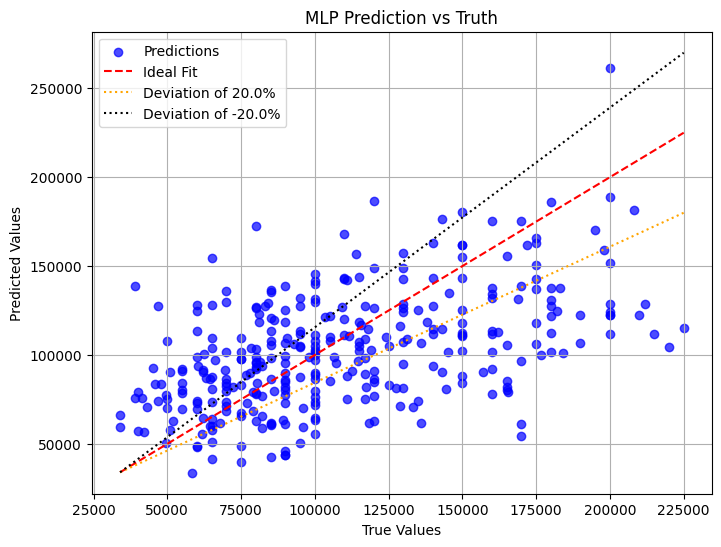

Mean Squared Error: 1555909157.19


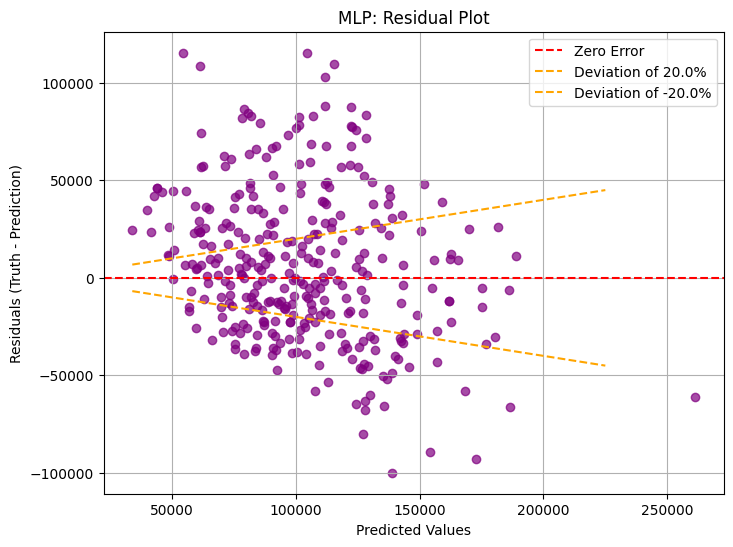

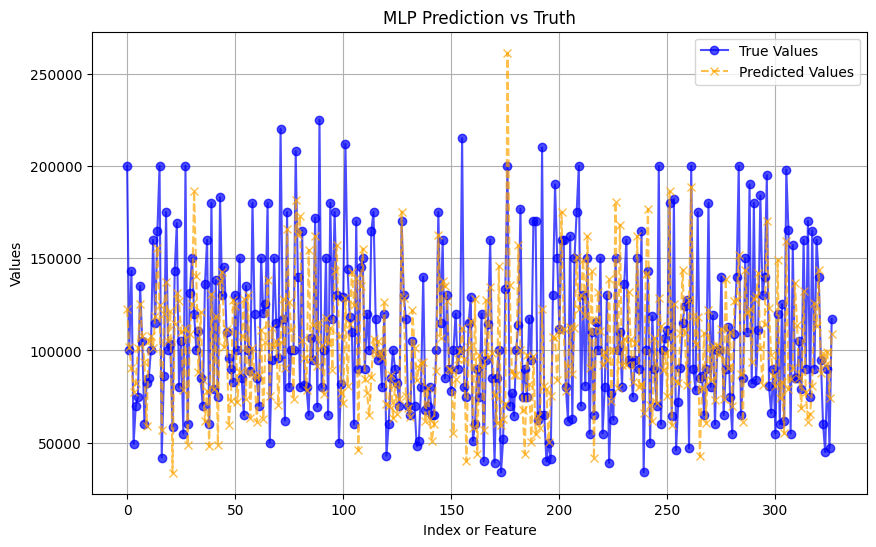

In [16]:
plot_prediction_vs_truth(y_min_test, y_min_pred, model="MLP")
plot_residuals(y_min_test, y_min_pred.flatten(), model="MLP")
plot_predictions_and_truth(y_min_test, y_min_pred, model="MLP")

# Evaluation for predicting max_salary

## SVM plots

In [ ]:
# plot_prediction_vs_truth(y_max_test, svr_predictions, model="SVM")
# plot_residuals(y_max_test, svr_predictions, model="SVM")
# plot_predictions_and_truth(y_max_test, svr_predictions, model="SVM")